# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [3]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [6]:
your_name = 'Raghu' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
457,57,female,29.58015,0,no,northwest,12195.998301
1050,44,female,35.84635,1,no,northwest,8263.829514
56,58,female,30.87025,2,no,northeast,14015.589813
311,19,female,23.95900,0,no,southwest,1789.497280
1288,20,male,38.21800,2,yes,southwest,39494.902980


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [10]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [11]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [15]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [16]:
categorical_cols = ['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [17]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

1155.530117 65683.5408503


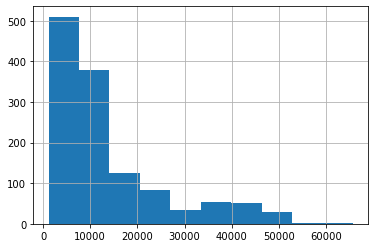

In [25]:
# Write your answer here
minimum = dataframe['charges'].min()
maximum = dataframe['charges'].max()
print(minimum, maximum)
dataframe['charges'].hist()

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [26]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/rrayanna/02-insurance-linear-regression


<IPython.core.display.Javascript object>

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [27]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [28]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[57.     ,  0.     , 29.58015,  0.     ,  0.     ],
        [44.     ,  0.     , 35.84635,  1.     ,  0.     ],
        [58.     ,  0.     , 30.87025,  2.     ,  0.     ],
        ...,
        [59.     ,  0.     , 33.756  ,  2.     ,  0.     ],
        [41.     ,  1.     , 27.936  ,  1.     ,  0.     ],
        [36.     ,  0.     , 29.1194 ,  0.     ,  0.     ]]),
 array([[12195.9983015],
        [ 8263.8295135],
        [14015.5898125],
        ...,
        [38017.9262709],
        [ 6470.70205  ],
        [ 5430.341074 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [29]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [30]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [31]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [32]:
val_percent = 0.18 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [33]:
batch_size = 64

In [34]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [35]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[47.0000,  1.0000, 35.1140,  1.0000,  0.0000],
        [47.0000,  0.0000, 25.8020,  2.0000,  0.0000],
        [57.0000,  1.0000, 42.3890,  1.0000,  0.0000],
        [26.0000,  0.0000, 19.2060,  1.0000,  0.0000],
        [18.0000,  0.0000, 30.4095,  0.0000,  0.0000],
        [57.0000,  0.0000, 36.8600,  2.0000,  0.0000],
        [61.0000,  1.0000, 22.9454,  0.0000,  0.0000],
        [54.0000,  1.0000, 30.6520,  0.0000,  0.0000],
        [19.0000,  1.0000, 33.0770,  0.0000,  0.0000],
        [51.0000,  1.0000, 30.6859,  0.0000,  0.0000],
        [29.0000,  0.0000, 25.2491,  0.0000,  0.0000],
        [43.0000,  0.0000, 29.0030,  1.0000,  0.0000],
        [42.0000,  0.0000, 36.7630,  0.0000,  0.0000],
        [62.0000,  1.0000, 36.2780,  0.0000,  0.0000],
        [27.0000,  0.0000, 20.8259,  0.0000,  0.0000],
        [40.0000,  0.0000, 22.6689,  3.0000,  0.0000],
        [43.0000,  1.0000, 24.7544,  5.0000,  0.0000],
        [48.0000,  1.0000, 28.7120,  0.0000,  0.0000],
  

Let's save our work by committing to Jovian.

In [36]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/rrayanna/02-insurance-linear-regression


<IPython.core.display.Javascript object>

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [37]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [38]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)        # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                             # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [39]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [40]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2566, -0.0864, -0.4107, -0.0400,  0.2633]], requires_grad=True),
 Parameter containing:
 tensor([-0.0321], requires_grad=True)]

One final commit before we train the model.

In [41]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/rrayanna/02-insurance-linear-regression


<IPython.core.display.Javascript object>

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [42]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [43]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13442.5791015625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [44]:
epochs = 120
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7722.0400
Epoch [40], val_loss: 6965.9097
Epoch [60], val_loss: 6888.1035
Epoch [80], val_loss: 6847.8945
Epoch [100], val_loss: 6810.3423
Epoch [120], val_loss: 6775.5967


In [45]:
epochs = 120
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6772.5278
Epoch [40], val_loss: 6769.2529
Epoch [60], val_loss: 6766.1704
Epoch [80], val_loss: 6763.1592
Epoch [100], val_loss: 6759.9478
Epoch [120], val_loss: 6757.2480


In [46]:
epochs = 240
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6756.9565
Epoch [40], val_loss: 6756.6465
Epoch [60], val_loss: 6756.3208
Epoch [80], val_loss: 6756.0210
Epoch [100], val_loss: 6755.7139
Epoch [120], val_loss: 6755.3833
Epoch [140], val_loss: 6755.0771
Epoch [160], val_loss: 6754.7378
Epoch [180], val_loss: 6754.4341
Epoch [200], val_loss: 6754.1084
Epoch [220], val_loss: 6753.7852
Epoch [240], val_loss: 6753.4663


In [47]:
epochs = 500
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6753.4346
Epoch [40], val_loss: 6753.4033
Epoch [60], val_loss: 6753.3730
Epoch [80], val_loss: 6753.3428
Epoch [100], val_loss: 6753.3140
Epoch [120], val_loss: 6753.2847
Epoch [140], val_loss: 6753.2559
Epoch [160], val_loss: 6753.2261
Epoch [180], val_loss: 6753.1963
Epoch [200], val_loss: 6753.1636
Epoch [220], val_loss: 6753.1348
Epoch [240], val_loss: 6753.1030
Epoch [260], val_loss: 6753.0718
Epoch [280], val_loss: 6753.0430
Epoch [300], val_loss: 6753.0107
Epoch [320], val_loss: 6752.9810
Epoch [340], val_loss: 6752.9497
Epoch [360], val_loss: 6752.9199
Epoch [380], val_loss: 6752.8877
Epoch [400], val_loss: 6752.8560
Epoch [420], val_loss: 6752.8252
Epoch [440], val_loss: 6752.7944
Epoch [460], val_loss: 6752.7622
Epoch [480], val_loss: 6752.7334
Epoch [500], val_loss: 6752.7031


In [48]:
epochs = 500
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6752.7012
Epoch [40], val_loss: 6752.6978
Epoch [60], val_loss: 6752.6948
Epoch [80], val_loss: 6752.6914
Epoch [100], val_loss: 6752.6885
Epoch [120], val_loss: 6752.6851
Epoch [140], val_loss: 6752.6826
Epoch [160], val_loss: 6752.6807
Epoch [180], val_loss: 6752.6782
Epoch [200], val_loss: 6752.6748
Epoch [220], val_loss: 6752.6729
Epoch [240], val_loss: 6752.6704
Epoch [260], val_loss: 6752.6680
Epoch [280], val_loss: 6752.6650
Epoch [300], val_loss: 6752.6641
Epoch [320], val_loss: 6752.6616
Epoch [340], val_loss: 6752.6587
Epoch [360], val_loss: 6752.6572
Epoch [380], val_loss: 6752.6543
Epoch [400], val_loss: 6752.6519
Epoch [420], val_loss: 6752.6494
Epoch [440], val_loss: 6752.6470
Epoch [460], val_loss: 6752.6450
Epoch [480], val_loss: 6752.6431
Epoch [500], val_loss: 6752.6406


**Q: What is the final validation loss of your model?**

In [49]:
val_loss = 6752.6406

Let's log the final validation loss to Jovian and commit the notebook

In [50]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [51]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/rrayanna/02-insurance-linear-regression


<IPython.core.display.Javascript object>

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [55]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [56]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([19.0000,  0.0000, 19.9820,  0.0000,  0.0000])
Target: tensor([1783.6273])
Prediction: tensor([4256.2432])


In [57]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([18.0000,  0.0000, 31.1564,  2.0000,  0.0000])
Target: tensor([2885.2966])
Prediction: tensor([4505.7935])


In [58]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([62.0000,  1.0000, 29.1194,  0.0000,  0.0000])
Target: tensor([13752.6631])
Prediction: tensor([12515.6592])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [59]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/rrayanna/02-insurance-linear-regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/rrayanna/02-insurance-linear-regression


<IPython.core.display.Javascript object>